In [1]:
import os
import tarfile
from six.moves import urllib
from zlib import crc32

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

In [2]:
DATA_SOURCE = (
    'https://raw.githubusercontent.com/ageron/handson-ml2/master')
HOUSING_URL = f'{DATA_SOURCE}/datasets/housing/housing.tgz'
DATA_DIR = '../../../data'

In [3]:
def fetch_housing_data():
    if not os.path.isdir(DATA_DIR):
        os.makedirs(DATA_DIR)
    tgz_path = os.path.join(DATA_DIR, 'housing.tgz')
    urllib.request.urlretrieve(HOUSING_URL, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(DATA_DIR)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
housing = pd.read_csv(f'{DATA_DIR}/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


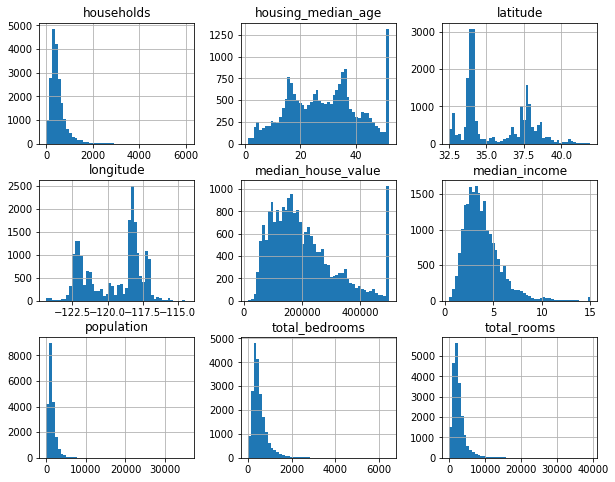

In [10]:
housing.hist(bins=50, figsize=(10, 8));

In [11]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [12]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
train_set.shape, test_set.shape

((16512, 11), (4128, 11))

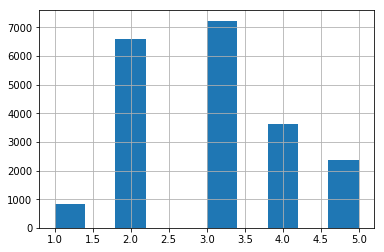

In [14]:
housing['income_cat'] = pd.cut(housing.median_income, 
                               bins=[0., 1.5, 3., 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])
housing.income_cat.hist();

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1103)
for train_idx, test_idx in split.split(housing, housing.income_cat):
    strat_train = housing.loc[train_idx]
    strat_test = housing.loc[test_idx]

In [16]:
for data in [strat_train, strat_test]:
    print(data.income_cat.value_counts() / len(data))

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [17]:
for data in (strat_train, strat_test):
    data.drop('income_cat', axis=1, inplace=True)

In [18]:
housing = strat_train.copy()

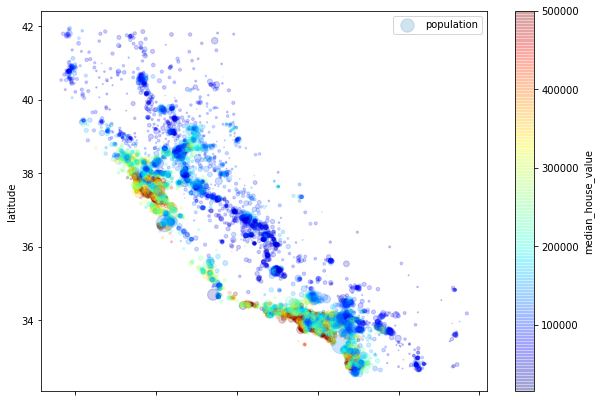

In [25]:
housing.plot(kind='scatter',
             x='longitude',
             y='latitude',
             alpha=0.2,
             s=housing['population'] / 100,
             label='population',
             figsize=(10, 7),
             c='median_house_value',
             cmap=plt.get_cmap('jet'),
             colorbar=True)
plt.legend();

In [26]:
corr_M = housing.corr()
corr_M['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691882
total_rooms           0.134490
housing_median_age    0.097914
households            0.066909
total_bedrooms        0.051152
population           -0.022312
longitude            -0.047664
latitude             -0.142845
Name: median_house_value, dtype: float64